# PREDICTOR - GMI_join_cc_cs_filtroPI_FCanarias

- SOLO PARA EL TOTAL  DE LAS ISLAS CANARIAS (NO TIENE FTV,GC,TNF...)
- TIENE LAS CARAECTEÍSTICAS DE CLIENTE
- TIENE LAS CARACTERÍSTICAS DE SOPORTE

# 04

# Proposito:

En este notebook nos dedicaremos a la creación del **predictor** para **gasto en alojamiento**

In [79]:
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2023-02-17T13:21:09.759218+00:00

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 126 Stepping 5, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [80]:
# Lectura y escritura de datos
# ==============================================================================
import os
import re

# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelado y Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Configuración warnings
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

**WARNING**
C:\Users\angel\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED

Solucion: !pip install --upgrade panda

# PREPARACION PREVIA

Primero necesitamos copiar todos nuestros archivos en una carpeta donde podramos manipularlos para así conservar los archivos originales

In [81]:
from distutils.dir_util import copy_tree

# Método que limpia la carpeta de datos volatiles ya que es 
# una carpeta activa en todos los programas que hemos generado.
def limpiaCarpetaVolatil(rutaCopia):
    print("Limpiando Carpeta Volatil...")
    for f in os.listdir(rutaCopia):
        os.remove(os.path.join(rutaCopia, f))
        
#Metodo que copia recursivamente
def copia(dir_origen,dir_destino):
    print("Copiando...")
    copy_tree(dir_origen, dir_destino)
    print("Copiado")
    print(os.listdir(dir_destino))
  


In [128]:
rutaBase= "../PredictorGastoTuristico/DatosPredictor/04/"
rutaCopia= "../PredictorGastoTuristico/DatosVolatiles/"

limpiaCarpetaVolatil(rutaCopia)
copia(rutaBase,rutaCopia)

Limpiando Carpeta Volatil...
Copiando...
Copiado
['GMI_join_cc_cs_filtroPI_F.csv']


## Primero cargamos los archivos para tratarlos y finalmente unirlos:

In [129]:
gasto_medio = pd.read_csv(rutaCopia+'GMI_join_cc_cs_filtroPI_F.csv',keep_default_na=False, na_values=[""])

In [130]:
gasto_medio.head()

,isla,fecha,Ingresos totales,RevPAR,ADR,pais,Total Turistas,Total Turistas Principales,Total Turistas Secundarios,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,gasto por turista otros,Establecimientos abiertos,Hab-aprt disponibles,Plazas ofertadas,Estancia media,Tasa ocupación por Hab-aprt,Tasa ocupación por plazas
0,Fuerteventura,2010Q1,90130386.63,35.486667,57.63,Alemania,143560.0,139893.0,3668.0,1040.55,473.62,334.83,232.11,491.0,83818.0,201847.0,11.193333,61.59,48.633333
1,Fuerteventura,2010Q1,90130386.63,35.486667,57.63,España,26503.0,23225.0,3278.0,692.60,271.42,175.27,245.91,491.0,83818.0,201847.0,4.090000,61.59,48.633333
2,Fuerteventura,2010Q1,90130386.63,35.486667,57.63,Holanda,8226.0,8155.0,71.0,1008.43,423.49,309.84,275.10,491.0,83818.0,201847.0,10.490000,61.59,48.633333
3,Fuerteventura,2010Q1,90130386.63,35.486667,57.63,Otros países,41629.0,40790.0,838.0,871.73,380.71,270.55,220.47,491.0,83818.0,201847.0,8.880000,61.59,48.633333
4,Fuerteventura,2010Q1,90130386.63,35.486667,57.63,Países Nórdicos,34385.0,34081.0,304.0,985.05,442.19,281.08,261.78,491.0,83818.0,201847.0,7.893333,61.59,48.633333


Los valores de correlación sólo se calcularán entre las columnas con valores numéricos. Por defecto, el método corr() utiliza el método Pearson para calcular el coeficiente de correlación. También podemos utilizar otros métodos como Kendall y spearman para calcular el coeficiente de correlación especificando el valor del parámetro method en el método corr.

Recuerda:

La correlación puede decir algo acerca de la relación entre las variables. Se utiliza para entender:

si la relación es positiva o negativa
la fuerza de la relación.

La correlación estadística es medida por lo que se denomina coeficiente de correlación (r). Su valor numérico varía de 1,0 a -1,0. Nos indica la fuerza de la relación.

Cuanto más cerca estén los coeficientes de +1,0 y -1,0, mayor será la fuerza de la relación entre las variables.

COnsejo:
 la correlación no implica causalidad
Las variables significativas en un modelo de regresión solo revelan correlación. La causalidad es un asunto completamente diferente. Por lo general, para establecer la causalidad, debe desarrollar y aplicar un experimento diseñado con aleatorización.

Sin embargo, la correlación puede ayudarnos a predecir el resultado, pero no siempre necesita variables que tengan relaciones causales con la variable respuesta.


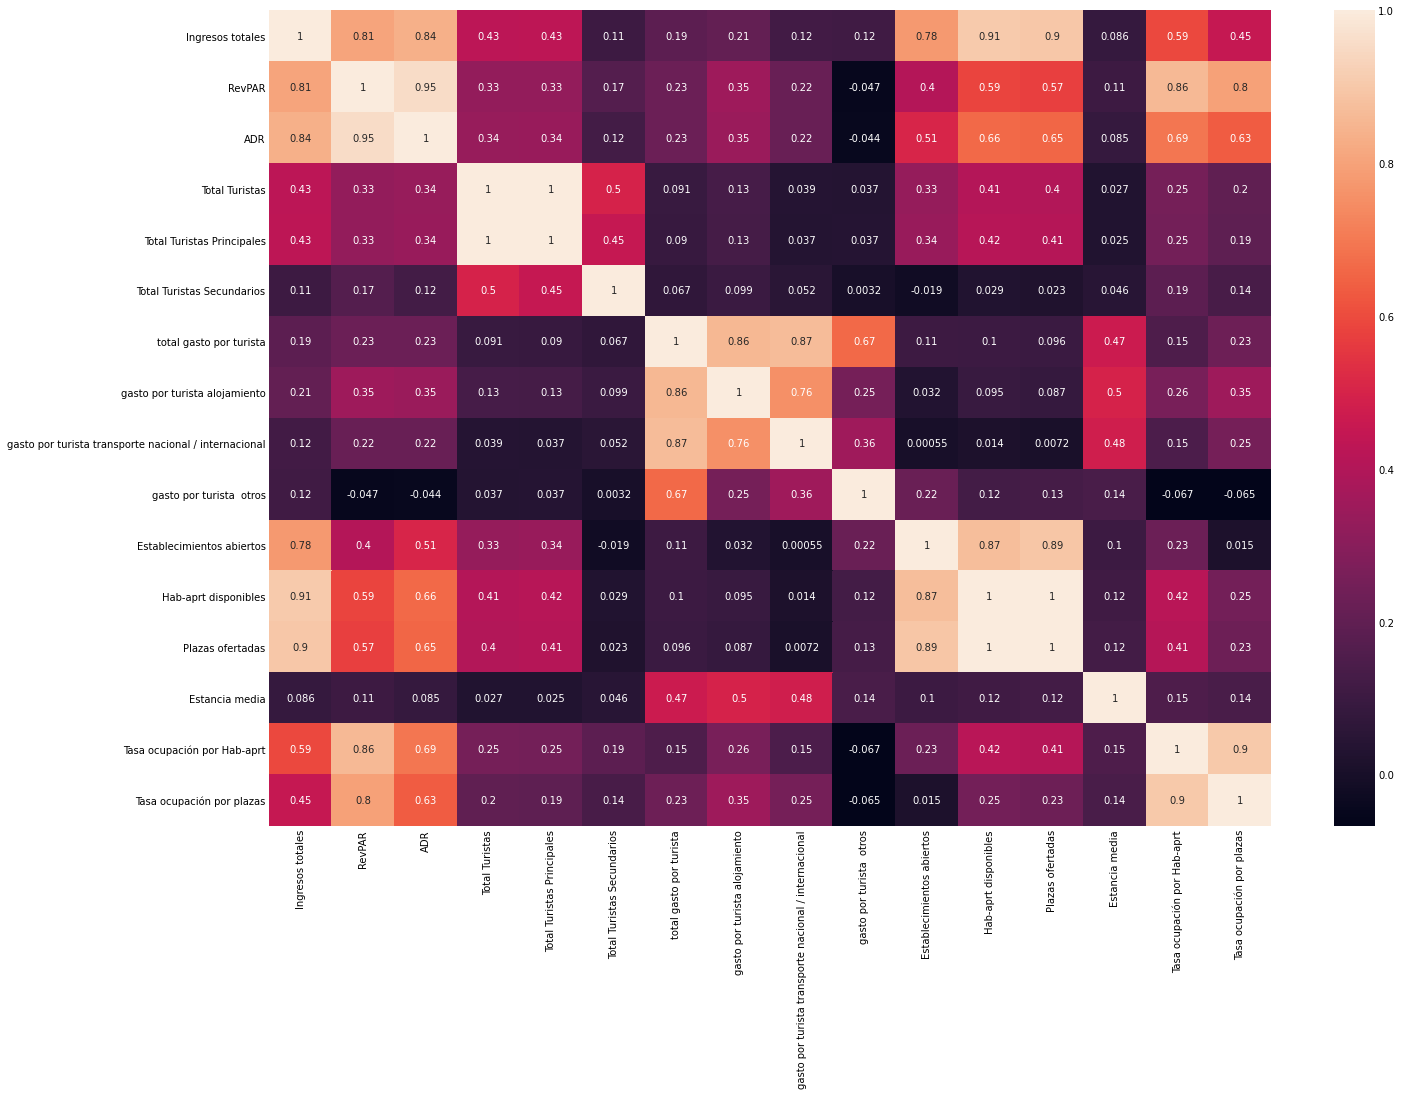

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_df = gasto_medio.corr(method='pearson', numeric_only = True)

plt.figure(figsize=(20, 15))
sns.heatmap(corr_df, annot=True)
plt.show()

IndexError: list index out of range

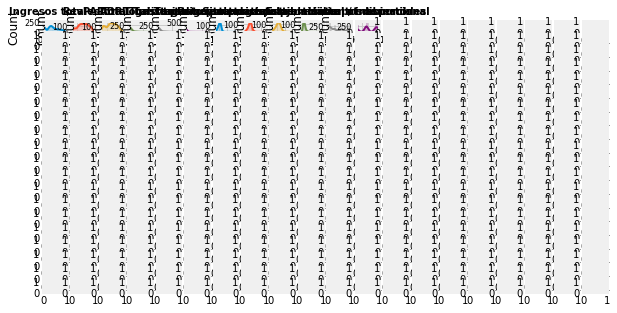

In [134]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=20, ncols=20, figsize=(9, 5))
axes = axes.flat
columnas_numeric = gasto_medio.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = gasto_medio,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

Convertimos la columan fecha en PeriodIndex, usando pd.PeriodIndex(). Una vez en dicho formato, se establece como índice.

In [85]:
###gasto_medio['fecha'] = pd.to_datetime(gasto_medio['fecha'], format='%YQ%m')
###gasto_medio = gasto_medio.set_index('fecha')
###gasto_medio = gasto_medio.asfreq('MS')
###gasto_medio = gasto_medio.sort_index() #Ordenamos
###gasto_medio.head()

In [86]:
gasto_medio['fecha'] = pd.PeriodIndex(gasto_medio.fecha, freq="Q", dtype='period[Q-DEC]')
gasto_medio = gasto_medio.set_index('fecha')

#gasto_medio = gasto_medio.asfreq('MS')

gasto_medio = gasto_medio.sort_index() #Ordenamos
gasto_medio.head()

,isla,Ingresos totales,RevPAR,ADR,pais,Total Turistas,Total Turistas Principales,Total Turistas Secundarios,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,gasto por turista otros,Establecimientos abiertos,Hab-aprt disponibles,Plazas ofertadas,Estancia media,Tasa ocupación por Hab-aprt,Tasa ocupación por plazas
fecha,,,,,,,,,,,,,,,,,,
2010Q1,Fuerteventura,9.013039e+07,35.486667,57.63,Alemania,143560.0,139893.0,3668.0,1040.55,473.62,334.83,232.11,491.0,83818.0,201847.0,11.193333,61.590000,48.633333
2010Q1,Gran Canaria,2.261325e+08,46.986667,59.64,Holanda,43503.0,43449.0,54.0,1095.18,452.68,330.03,312.47,1847.0,159474.0,417275.0,10.923333,78.783333,62.666667
2010Q1,Gran Canaria,2.261325e+08,46.986667,59.64,Otros países,111729.0,110316.0,1414.0,1053.71,460.16,296.74,296.80,1847.0,159474.0,417275.0,9.153333,78.783333,62.666667
2010Q1,Gran Canaria,2.261325e+08,46.986667,59.64,Países Nórdicos,306650.0,305962.0,688.0,1219.30,457.09,300.02,462.19,1847.0,159474.0,417275.0,8.706667,78.783333,62.666667
2010Q1,Gran Canaria,2.261325e+08,46.986667,59.64,Reino Unido,110131.0,107916.0,2215.0,765.50,316.80,198.22,250.48,1847.0,159474.0,417275.0,8.780000,78.783333,62.666667


In [87]:
gasto_medio.shape

(1390, 18)

In [88]:
df = pd.get_dummies(gasto_medio, columns=['pais','isla'])
df.head()

,Ingresos totales,RevPAR,ADR,Total Turistas,Total Turistas Principales,Total Turistas Secundarios,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,gasto por turista otros,...,pais_Holanda,pais_Otros países,pais_Países Nórdicos,pais_Reino Unido,pais_TOTAL,isla_Fuerteventura,isla_Gran Canaria,isla_La Palma,isla_Lanzarote,isla_Tenerife
fecha,,,,,,,,,,,,,,,,,,,,,
2010Q1,9.013039e+07,35.486667,57.63,143560.0,139893.0,3668.0,1040.55,473.62,334.83,232.11,...,0,0,0,0,0,1,0,0,0,0
2010Q1,2.261325e+08,46.986667,59.64,43503.0,43449.0,54.0,1095.18,452.68,330.03,312.47,...,1,0,0,0,0,0,1,0,0,0
2010Q1,2.261325e+08,46.986667,59.64,111729.0,110316.0,1414.0,1053.71,460.16,296.74,296.80,...,0,1,0,0,0,0,1,0,0,0
2010Q1,2.261325e+08,46.986667,59.64,306650.0,305962.0,688.0,1219.30,457.09,300.02,462.19,...,0,0,1,0,0,0,1,0,0,0
2010Q1,2.261325e+08,46.986667,59.64,110131.0,107916.0,2215.0,765.50,316.80,198.22,250.48,...,0,0,0,1,0,0,1,0,0,0


In [89]:
df.dtypes

Ingresos totales                                         float64
RevPAR                                                   float64
ADR                                                      float64
Total Turistas                                           float64
Total Turistas Principales                               float64
Total Turistas Secundarios                               float64
total gasto por turista                                  float64
gasto por turista alojamiento                            float64
gasto por turista transporte nacional / internacional    float64
gasto por turista  otros                                 float64
Establecimientos abiertos                                float64
Hab-aprt disponibles                                     float64
Plazas ofertadas                                         float64
Estancia media                                           float64
Tasa ocupación por Hab-aprt                              float64
Tasa ocupación por plazas

In [90]:
gasto_medio = df
gasto_medio.head()

,Ingresos totales,RevPAR,ADR,Total Turistas,Total Turistas Principales,Total Turistas Secundarios,total gasto por turista,gasto por turista alojamiento,gasto por turista transporte nacional / internacional,gasto por turista otros,...,pais_Holanda,pais_Otros países,pais_Países Nórdicos,pais_Reino Unido,pais_TOTAL,isla_Fuerteventura,isla_Gran Canaria,isla_La Palma,isla_Lanzarote,isla_Tenerife
fecha,,,,,,,,,,,,,,,,,,,,,
2010Q1,9.013039e+07,35.486667,57.63,143560.0,139893.0,3668.0,1040.55,473.62,334.83,232.11,...,0,0,0,0,0,1,0,0,0,0
2010Q1,2.261325e+08,46.986667,59.64,43503.0,43449.0,54.0,1095.18,452.68,330.03,312.47,...,1,0,0,0,0,0,1,0,0,0
2010Q1,2.261325e+08,46.986667,59.64,111729.0,110316.0,1414.0,1053.71,460.16,296.74,296.80,...,0,1,0,0,0,0,1,0,0,0
2010Q1,2.261325e+08,46.986667,59.64,306650.0,305962.0,688.0,1219.30,457.09,300.02,462.19,...,0,0,1,0,0,0,1,0,0,0
2010Q1,2.261325e+08,46.986667,59.64,110131.0,107916.0,2215.0,765.50,316.80,198.22,250.48,...,0,0,0,1,0,0,1,0,0,0


**Variables Dummy**

Es necesario recordar que pada evitar la multicolineaidad debemos quitar una columna de las variables dummy que creamos, ya que si las ponemos todas creamos una dependencia circular.

### NOTA:
**Para evitar el sigueiente error:**

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

**Debemos eliminar los valores nulos de las columnas del df**

In [91]:
gasto_medio.isnull().sum()

Ingresos totales                                         0
RevPAR                                                   0
ADR                                                      0
Total Turistas                                           0
Total Turistas Principales                               0
Total Turistas Secundarios                               0
total gasto por turista                                  0
gasto por turista alojamiento                            0
gasto por turista transporte nacional / internacional    0
gasto por turista  otros                                 0
Establecimientos abiertos                                0
Hab-aprt disponibles                                     0
Plazas ofertadas                                         0
Estancia media                                           0
Tasa ocupación por Hab-aprt                              0
Tasa ocupación por plazas                                0
pais_Alemania                                           

In [92]:
gasto_medio = gasto_medio.dropna()

In [93]:
gasto_medio.columns

Index(['Ingresos totales', 'RevPAR', 'ADR', 'Total Turistas',
       'Total Turistas Principales', 'Total Turistas Secundarios',
       'total gasto por turista', 'gasto por turista alojamiento',
       'gasto por turista transporte nacional / internacional',
       'gasto por turista  otros', 'Establecimientos abiertos',
       'Hab-aprt disponibles', 'Plazas ofertadas', 'Estancia media',
       'Tasa ocupación por Hab-aprt', 'Tasa ocupación por plazas',
       'pais_Alemania', 'pais_España', 'pais_Holanda', 'pais_Otros países',
       'pais_Países Nórdicos', 'pais_Reino Unido', 'pais_TOTAL',
       'isla_Fuerteventura', 'isla_Gran Canaria', 'isla_La Palma',
       'isla_Lanzarote', 'isla_Tenerife'],
      dtype='object')

- **quite total gasto por turista** ya que me al final es la suma de todos los gastos asique facilira la predicción... al ser una variable dependiente de otras, aporta demasasida infromación ¿NO?
- **quite gasto por turita alojamiento** porque es la variable a predecir...
- **quite isla_Tenerife**  para evitar la multicolinealidad de las **variables dummy**
- **quite pais_Total** para evitar la multicolinealidad de las **variables dummy**


In [94]:
nombres_variables_independientes = [
    
       'Ingresos totales', 'RevPAR', 'ADR', 'Total Turistas',
       'Total Turistas Principales', 'Total Turistas Secundarios',
       
       'gasto por turista transporte nacional / internacional',
       'gasto por turista  otros', 
    
       'Establecimientos abiertos',
       'Hab-aprt disponibles', 'Plazas ofertadas', 'Estancia media',
       'Tasa ocupación por Hab-aprt', 'Tasa ocupación por plazas',
    
       'pais_Alemania', 'pais_España', 'pais_Holanda', 'pais_Otros países',
       'pais_Países Nórdicos', 'pais_Reino Unido',
    
       'isla_Fuerteventura', 'isla_Gran Canaria', 'isla_La Palma',
       'isla_Lanzarote'
        ]

In [95]:
gasto_medio[nombres_variables_independientes]

,Ingresos totales,RevPAR,ADR,Total Turistas,Total Turistas Principales,Total Turistas Secundarios,gasto por turista transporte nacional / internacional,gasto por turista otros,Establecimientos abiertos,Hab-aprt disponibles,...,pais_Alemania,pais_España,pais_Holanda,pais_Otros países,pais_Países Nórdicos,pais_Reino Unido,isla_Fuerteventura,isla_Gran Canaria,isla_La Palma,isla_Lanzarote
fecha,,,,,,,,,,,,,,,,,,,,,
2010Q1,9.013039e+07,35.486667,57.630000,143560.0,139893.0,3668.0,334.83,232.11,491.0,83818.0,...,1,0,0,0,0,0,1,0,0,0
2010Q1,2.261325e+08,46.986667,59.640000,43503.0,43449.0,54.0,330.03,312.47,1847.0,159474.0,...,0,0,1,0,0,0,0,1,0,0
2010Q1,2.261325e+08,46.986667,59.640000,111729.0,110316.0,1414.0,296.74,296.80,1847.0,159474.0,...,0,0,0,1,0,0,0,1,0,0
2010Q1,2.261325e+08,46.986667,59.640000,306650.0,305962.0,688.0,300.02,462.19,1847.0,159474.0,...,0,0,0,0,1,0,0,1,0,0
2010Q1,2.261325e+08,46.986667,59.640000,110131.0,107916.0,2215.0,198.22,250.48,1847.0,159474.0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019Q4,1.793530e+08,67.543333,84.576667,747450.0,707216.0,40234.0,353.35,302.01,777.0,86657.0,...,0,0,0,0,0,0,0,0,0,1
2019Q4,1.793530e+08,67.543333,84.576667,340951.0,340790.0,162.0,357.43,283.28,777.0,86657.0,...,0,0,0,0,0,1,0,0,0,1
2019Q4,1.793530e+08,67.543333,84.576667,35991.0,35863.0,129.0,677.79,310.53,777.0,86657.0,...,0,0,0,0,1,0,0,0,0,1


In [96]:
nombre_variable_objetiva = ['gasto por turista alojamiento']

# AQUÍ DIVIDIMOS EL DATASET EN TRAIN Y TEST

In [97]:
aux1 = gasto_medio[nombres_variables_independientes]
aux2 = gasto_medio[nombre_variable_objetiva]

In [98]:
aux2.head()

,gasto por turista alojamiento
fecha,
2010Q1,473.62
2010Q1,452.68
2010Q1,460.16
2010Q1,457.09
2010Q1,316.80


Fechas train : 2010Q1 --- 2017Q1  (n=973)
Fechas test  : 2017Q1 --- 2019Q4  (n=417)
Fechas train variable objetivo: 2010Q1 --- 2017Q1  (n=973)
Fechas test variable objetivo: 2017Q1 --- 2019Q4  (n=417)


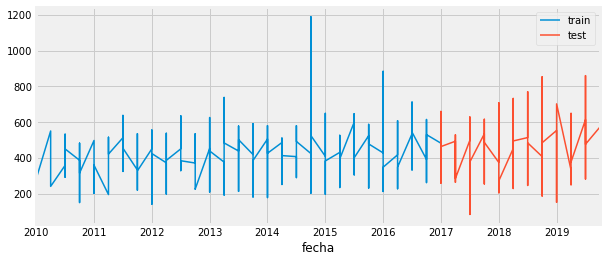

In [112]:
# Separación datos train-test
# ==============================================================================

# el data set tiene 1390 filas y 24 columnas
# hay 10 fechas distintas asique steps = 1390/10 = 139 que es la cantidad de steps para visualizar un año
# esto pasa porque hay 10 fechas diferentes, pero tambien hay 7 paises y 5 islas diferentes, por lo que el numero
# de ocurrencias de una misma fecha es multiple.

# por tanto para coger e test 2018 y 2019, steps debe valer 139*2 = 278
# para 2017 - 2019 139*3 = 417
steps = 139*3
X_train = aux1[:-steps]
X_test  = aux1[-steps:]

Y_train = aux2[:-steps]
Y_test  = aux2[-steps:]

print(f"Fechas train : {X_train.index.min()} --- {X_train.index.max()}  (n={len(X_train)})")
print(f"Fechas test  : {X_test.index.min()} --- {X_test.index.max()}  (n={len(X_test)})")


print(f"Fechas train variable objetivo: {Y_train.index.min()} --- {Y_train.index.max()}  (n={len(Y_train)})")
print(f"Fechas test variable objetivo: {Y_test.index.min()} --- {Y_test.index.max()}  (n={len(Y_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
Y_train['gasto por turista alojamiento'].plot(ax=ax, label='train')
Y_test['gasto por turista alojamiento'].plot(ax=ax, label='test')
ax.legend();

# PREDICTOR

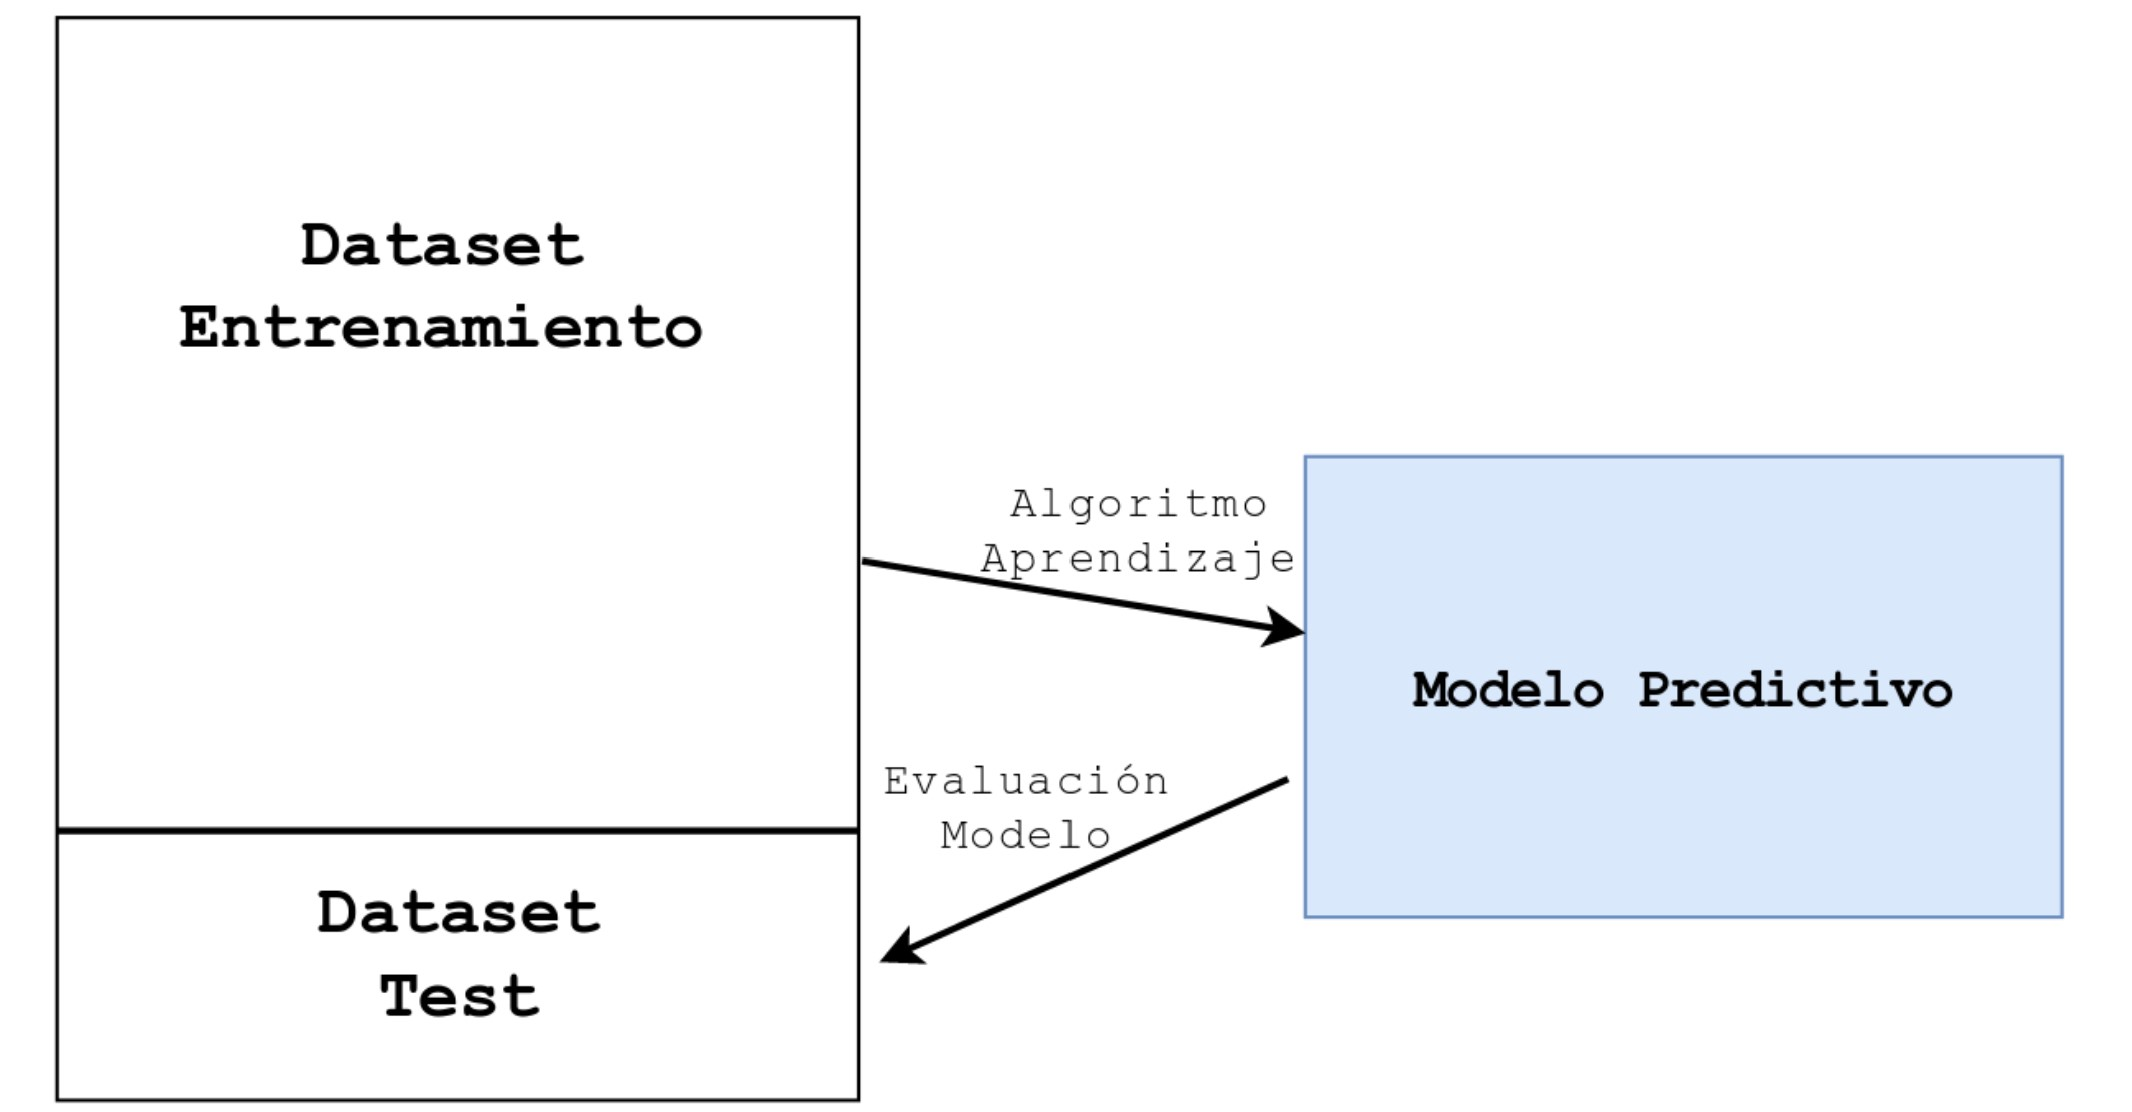

In [113]:
from IPython.display import Image

Image("../PredictorGastoTuristico/OtrosRecursos/Imagenes/img01.jpg")

## MEDIDAS DE EVALUACIÓN DEL MODELO

In [114]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score

Aqui definimso las **Medidas de evaluación:**

    - RMSE (Root Mean Squared Error) Raiz cuadrada del error absoluto medio al cuadrado
    - adjusted_r2 Coeficiente de Determinacion ajustado
    - MAE (Mean Absolute error)

In [115]:
def rmse(objetivo, estimaciones):
    return np.sqrt(metrics.mean_squared_error(objetivo, estimaciones))

def adjusted_r2(objetivo, estimaciones, n, k):
    r2 = metrics.r2_score(objetivo, estimaciones)
    return 1 - (1-r2)*(n-1) / (n - k - 1)

def evaluar_modelo(objetivo, estimaciones, n, k):
    return {
        "rmse": rmse(objetivo, estimaciones),
        "mae": metrics.mean_absolute_error(objetivo, estimaciones),
        "adjusted_r2": adjusted_r2(objetivo, estimaciones, n, k),
           }


# AQUÍ AJUSTAMOS EL MODELO DE REGRESION LINEAL MÚLTIPLE

Ademas, evaluamos el modelo de entrenamiento y test

In [116]:
RESULTADOS_OLS = {}

modelo_ols = LinearRegression()
modelo_ols.fit(X=X_train, y=Y_train)
modelo_ols_train_preds = modelo_ols.predict(X_train)
modelo_ols_test_preds = modelo_ols.predict(X_test)


RESULTADOS_OLS["OLS_train"] = evaluar_modelo(
    Y_train,
    modelo_ols_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

RESULTADOS_OLS["OLS_test"] = evaluar_modelo(
    Y_test,
    modelo_ols_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

pd.DataFrame(RESULTADOS_OLS)

,OLS_train,OLS_test
rmse,32.827686,110.080354
mae,18.968136,71.009426
adjusted_r2,0.871610,-0.035341


In [117]:
gasto_medio["gasto por turista alojamiento"].describe()

count    1390.000000
mean      438.141180
std        99.594708
min        84.860000
25%       378.190000
50%       442.410000
75%       495.082500
max      1188.760000
Name: gasto por turista alojamiento, dtype: float64

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

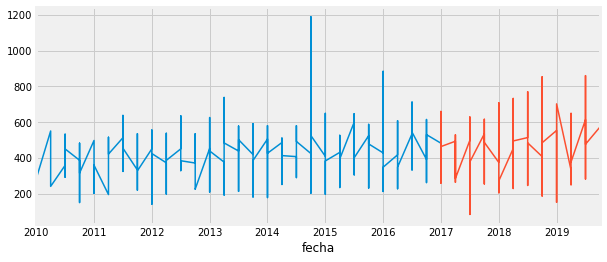

In [118]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
Y_train['gasto por turista alojamiento'].plot(ax=ax, label='train')
Y_test['gasto por turista alojamiento'].plot(ax=ax, label='test')
modelo_ols_test_preds.plot(ax=ax, label='predicciones')
ax.legend();

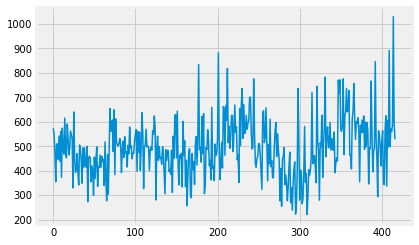

In [119]:
plt.plot(modelo_ols_test_preds)
plt.show()

In [ ]:
Y_train.head()

In [ ]:
print(modelo_ols_test_preds)

In [ ]:
BREKKKKKKK

# 2. MODELO XGBoost

## (GRADIENT_BOOSTING)


La regresión lineal es uno de los muchos algoritmos que se pueden utilizar para resolver problemas de regresión. Es posible que otros algoritmos de regresión produzcan mejores resultados. La estrategia general consiste en experimentar con diferentes regresores para comparar puntuaciones.

**Hay una amplia gama de regresores, incluidos árboles de decisión, bosques aleatorios, aumento de gradiente XGBoost**

Aquí usaresmos el XGBoost que incluye un regresor, llamado XGBRegressor, que puede usarse en cualquier conjunto de datos de regresión. 

Usemos ahora XGBRegressor para comparar los resultados del conjunto de datos de gasto con los datos que obtuvimos en la regresión lineal.

Primero hay que instalarlo si no lo tenemos: **pip install xgboost**

In [120]:
from xgboost import XGBRegressor

In [121]:
RESULTADOS_XGBR = {}

xg_reg = XGBRegressor()
xg_reg.fit(X=X_train, y=Y_train)
xg_reg_train_preds = xg_reg.predict(X_train)
xg_reg_test_preds = xg_reg.predict(X_test)


RESULTADOS_XGBR["XGBR_train"] = evaluar_modelo(
    Y_train,
    xg_reg_train_preds,
    X_train.shape[0],
    len(modelo_ols.coef_)
)

RESULTADOS_XGBR["XGBR_test"] = evaluar_modelo(
    Y_test,
    xg_reg_test_preds,
    X_test.shape[0],
    len(modelo_ols.coef_)
)

pd.DataFrame(RESULTADOS_XGBR)

,XGBR_train,XGBR_test
rmse,1.673346,115.875924
mae,1.189454,71.772988
adjusted_r2,0.999666,-0.147230


In [122]:
pd.DataFrame(RESULTADOS_OLS)

,OLS_train,OLS_test
rmse,32.827686,110.080354
mae,18.968136,71.009426
adjusted_r2,0.871610,-0.035341


In [123]:
RESULTADOS = pd.merge(pd.DataFrame(RESULTADOS_OLS),pd.DataFrame(RESULTADOS_XGBR), how="outer", left_index=True, right_index=True)
RESULTADOS.head()

,OLS_train,OLS_test,XGBR_train,XGBR_test
rmse,32.827686,110.080354,1.673346,115.875924
mae,18.968136,71.009426,1.189454,71.772988
adjusted_r2,0.871610,-0.035341,0.999666,-0.147230


In [ ]:
breeeekl

In [ ]:
# Separación datos train-test
# ==============================================================================
# steps = num_Quartiles (4) * num_años (3) * num_Paises (7) = 84
# es comun que step sea 36, referido a meses, pero nosotros tenemos la particularidad de que tenemos las fechas en cuartiles
# y tenemos 7 fechas iguales para 7 paises diferentes, es por ello por lo que debemos hacer que 
# step = 4 * 7 * 3 = 84
steps = 84
datos_train = gasto_medio[:-steps]
datos_test  = gasto_medio[-steps:]

print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(9, 4))
datos_train['gasto por turista alojamiento'].plot(ax=ax, label='train')
datos_test['gasto por turista alojamiento'].plot(ax=ax, label='test')
ax.legend();

In [ ]:
datos_train.tail()

In [ ]:
ForecasterAutoreg?

# ForecasterAutoreg

Se crea y entrena un modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
# lags = 1quartil * 7paises = 7 -> que equivale a 3 meses
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 28
                index_type : "Q-Dec"
             )

forecaster.fit(y=datos_train['gasto por turista alojamiento'])
forecaster

# Predicciones


Una vez entrenado el modelo, se predicen los datos de test (3 años a futuro).

steps = num_Quartiles (4) * num_años (3) * num_Paises (7) = 84

In [ ]:
# Predicciones
# ==============================================================================
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

In [ ]:
# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
datos_train['gasto por turista alojamiento'].plot(ax=ax, label='train')
datos_test['gasto por turista alojamiento'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['gasto por turista alojamiento'],
                y_pred = predicciones
            )

print(f"Error de test (mse): {error_mse}")

In [ ]:
brekkkkkkkkkk

# VISUALIZACION SENCILLA - SALTAR

In [ ]:
#modelo_olsS = LinearRegression()
#modelo_olsS.fit(X=X_train, y=y_train)

In [ ]:
#y_pred = modelo_olsS.predict(X_test)

In [ ]:
#print(y_pred)

In [ ]:
#print(y_test)